# Dependencies

In [1]:
%matplotlib inline
%precision 32
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.sparse import csr_matrix, diags, kron, eye, csc_matrix, tril, triu
from scipy.sparse.linalg import LinearOperator, spilu, gmres, inv
from numpy.linalg import norm
import time

# Preconditioner M

### Construct $M_{mos-d}$ Preconditioner: Direct Construction

In [2]:
def mos_d_preconditioner(A, m):
    n = A.shape[0]
    T = diags(abs(A.diagonal()), 0)
    T_inv = diags(1 / abs(A.diagonal()), 0)
    E = 1/(m+1)*T_inv * (diags(A.diagonal(), 0)-T)
    J = diags(np.ones(n),0) +E

    # off-diagonal matrice in the paper, not defined specifically
    A_dblprimes=[]
    for i in range(m+1):
        A_dblprimes.append(csr_matrix((n,n)))
    A_primes = []
    for l in range(m+1):
        A_prime = J.power(-(m- 1 -l))* A_dblprimes[l] *J.power(-l)
        A_primes.append(A_prime)
    M_primes = []
    for l in range(m+1):
        M_prime = (T * E + A_primes[l])
        M_primes.append(M_prime)

    
    M = (diags(np.ones(n), 0)+T_inv * M_primes[0])
    for l in range(1, m+1):
        M @= (diags(np.ones(n), 0)+T_inv * M_primes[l])
    M = T @ M
    return csr_matrix(inv(csc_matrix(M)))


### Construct $M_{mos-a}$ Preconditioner: Adaptive Construction

In [3]:
def off_diagonal(matrix, index):
    if isinstance(matrix, np.ndarray):
        row = matrix[index, :]
    else:
        row = matrix.getrow(index).toarray()[0]
    off_diago= row.copy()
    off_diago[index] = 0
    return off_diago

In [4]:
def max_indices(a, k):
    return np.argpartition(a, -k)[-k: ]

In [5]:
def S_max(A, q):
    n = A.shape[0]
    S_max_set = set()
    for i in range(n):
        off_diag = np.abs(off_diagonal(A, i))
        max_index = max_indices(off_diag, q[i])
        for j in max_index:
            S_max_set.add((i, j))
    return S_max_set

In [6]:
def prune(A, S):
    prune1 = []
    prune2 = []
    prune3 = [0]
    count=0
    for i in range(A.shape[0]):
        row_ele=[]
        row_index=[]
        for j in range(A.shape[0]):
            if (i, j) in S:
                row_ele.append(A[i, j])
                row_index.append(j)
                count+=1
        prune1.extend(row_ele)
        prune2.extend(row_index)
        prune3.append(count)
    return csr_matrix((prune1,prune2,prune3), shape=(A.shape[0],A.shape[0]))

In [7]:
# Since for our testing sparse matrices, diagonal is never going be to zero, so unit(x) will always output the norm of the value
def diagp1(A):
        su = np.abs(A).sum(axis=1).A1
        output = np.linalg.norm(A.diagonal())*np.maximum(np.abs(A.diagonal()), su-np.abs(A.diagonal()))
        return diags(output, 0)

In [8]:
def mos_a_preconditioner(A, m, q):
    n = A.shape[0]
    # we use set notation since in the paper, they also use the set notation
    S_diag = set()

    for i in range(n):
        for j in range(n):
            if i == j:
                S_diag.add((i, j))

    B   = list(np.zeros(m + 1))
    M   = list(np.zeros(m + 1))
    S_B = list(np.zeros(m + 2))
    S_M = list(np.zeros(m + 1))

    S_B[0] = S_diag.union(S_max(A, q))
    B[0]   = prune(A, S_B[0])
    S_M[0] = S_diag.union(S_max(B[0], q))

    
    for l in range(1, m+1):
       
        M[l-1] = prune(B[l-1], S_M[l-1]).toarray()

        M_inv =np.linalg.inv(M[l-1])

        S_B[l]= S_diag.union(S_max(B[l-1].dot(M_inv) , q))
        B[l]= prune(B[l - 1].dot(M_inv) , S_B[l])
        S_M[l] = S_diag.union(S_max(B[l], q))
    
    T = diagp1(B[-1])

    M_mos = M[0]
    for l in range(1, m):
        M_mos = M_mos @ M[l]
    M_mos = T @ M_mos

    return csr_matrix(np.linalg.inv(M_mos))


# Matrix A

### Sparse Matrices

In [9]:
# 5-point 2D stencil
def five_pt_stencil(n):
    h = 1.0/(n+1)

    Ap = diags([-4.0 * np.ones(n), np.ones(n-1), np.ones(n-1), np.ones(n-2), np.ones(n-2)], [0, 1, -1, 2, -2])
    A = (1/(h**2)) * kron(Ap,np.eye(n)) +kron(np.eye(n), Ap)

    return csr_matrix(A)

In [10]:
# 9-point 2D stencil
def nine_pt_stencil(n):
    h = 1.0/(n + 1)

    A = (1/(6 *(h**2)))*diags([-20.0 * np.ones((n * n)), 
                                    np.concatenate((4.0 * np.ones(n-1), np.zeros((n*n)-n)), axis=0), 
                                    np.concatenate((4.0 * np.ones(n-1), np.zeros((n*n)-n)), axis=0)[::-1], 
                                    4.0 * np.ones((n * n) - n), 
                                    4.0 * np.ones((n * n) - n)[::-1],
                                    np.concatenate((np.zeros(n), np.ones((n*n)-n)), axis=0), 
                                    np.concatenate((np.zeros(n), np.ones((n*n)-n)), axis=0)[::-1], 
                                    np.concatenate((np.zeros(n), np.ones((n*n)-n)), axis=0)[::-1], 
                                    np.concatenate((np.zeros(n), np.ones((n*n)-n)), axis=0)[::-1][::-1]],
        [0, 1, -1, n, -n, n + 1, -(n + 1), n - 1, -(n - 1)])

    return csr_matrix(A)

In [11]:
# 27-point 3D stencil
def twenty_seven_pt_stencil(n):
    h = 1.0/(n + 1)
    
    diag = -26.0*np.ones((n**3))
    diag1 = np.concatenate((6.0 * np.ones(n-1), np.zeros((n**3) - n)), axis=0)
    diag2 = np.concatenate((np.zeros(n), 2.0 * np.ones((n**3) - n)), axis=0)
    diag3 = np.concatenate((1.0 * np.ones(n-1), np.zeros(1), np.zeros((n**3) - n)), axis=0)
    diag4 = np.concatenate((np.zeros(n*n), 1.0 * np.ones((n**3) - n * n)), axis=0)
    diag5 = np.concatenate((np.zeros(n), 1.0 * np.ones((n**3) - n * n - n)), axis=0)
    diag6 = np.concatenate((np.zeros(n-1), 1.0 * np.ones((n**3) - n * n - n - n + 1)), axis=0)

    A = (1 / (6 * (h**2))) * diags([diag,
                    diag1, diag1[::-1],
                    diag2, diag2[::-1],
                    diag3, diag3[::-1],
                    diag4, diag4[::-1],
                    diag5, diag5[::-1],
                    diag6, diag6[::-1]],
        [0,
        1, -1,
        n, -n,
        n+1, -(n+1),
        n**2, -(n**2),
        n**2 + n, -(n**2 + n),
        n**2 + n + 1, -(n**2 + n + 1)])

    
    return csr_matrix(A)


In [12]:
# 2D rotated anisotropic stencil, parameters including rotation angle and anisotropic coefficient. We used fixed theta and epsilon here, but this can be changed for sure.
def rotated_anisotropic_stencil(n, theta = np.pi/4 , epsilon = np.array([[1.0, 0.0], [0.0, 0.1]])  ):
    h = 1.0/(n + 1)
    Rotation = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    alpha = epsilon[0,0]
    beta = epsilon[1,1]
    rotation_coeff = Rotation @ np.array([-1, 1])
    diag = -2.0 * (alpha + beta) * np.ones(n**2)
    diag1 = np.concatenate((alpha * np.ones(n - 1), np.zeros(n**2 - n)), axis=0)
    diag2 = beta * np.ones(n**2- n)
    diag3 = (alpha - beta) * rotation_coeff[0] * np.concatenate((np.ones(n-1), np.zeros(n**2-n)), axis=0)
    diag4 = (alpha - beta) * rotation_coeff[1] * np.concatenate((np.zeros(n-1), np.ones(n-1), np.zeros(n**2-2*n)), axis=0)

    A = (1/(h**2))*diags([diag, 
                              diag1,diag1[::-1], 
                              diag2,diag2[::-1], 
                              diag3,diag3[::-1], 
                              diag4,diag4[::-1]],
            [0, 1, -1, n, -n, n + 1, -(n + 1), n - 1, -(n - 1)])

    
    return csr_matrix(A)



# Test

### Test M_mos_d

In [13]:
n = 10
A = rotated_anisotropic_stencil(n)
b = np.random.rand(n**2) # for 2 dimensional stencil
# b = np.random.rand(n**3) # for 3 dimensional stencil

true_x = np.linalg.solve(A.toarray(), b)

In [14]:
class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.initial_residual_norm = None

    def __call__(self, rk=None):
        self.niter += 1
        if self.initial_residual_norm is None:
            self.initial_residual_norm = rk

        relative_residual_norm = rk / self.initial_residual_norm

        if self._disp:
            print('iter %3i\t|rk|/|r0| = %s' % (self.niter, str(relative_residual_norm)))

counter = gmres_counter()
m = 2
start = time.time()
M = mos_d_preconditioner(A, m)
x_gmres, info = gmres(A, b, maxiter = 100, tol=1e-9, M=M,callback=counter)

print(counter.niter)
error = norm(true_x - x_gmres)
print("Execution time:", time.time()-start)
print("Norm of error:", error)

iter   1	|rk|/|r0| = 1.0
iter   2	|rk|/|r0| = 0.4412722958796329
iter   3	|rk|/|r0| = 0.1816677384598735
iter   4	|rk|/|r0| = 0.07616808847635785
iter   5	|rk|/|r0| = 0.033510654256330825
iter   6	|rk|/|r0| = 0.012809744479396574
iter   7	|rk|/|r0| = 0.005035427004699606
iter   8	|rk|/|r0| = 0.0021525354116010875
iter   9	|rk|/|r0| = 0.0007982188056608457
iter  10	|rk|/|r0| = 0.00011229990953850619
iter  11	|rk|/|r0| = 8.300302845198472e-06
iter  12	|rk|/|r0| = 5.573993995417083e-07
iter  13	|rk|/|r0| = 2.8522964602055327e-08
iter  14	|rk|/|r0| = 1.3988781072133235e-09
14
Execution time: 0.07575392723083496
Norm of error: 5.9159511420541696e-12


### Compare gmres with jacobi preconditioner:

In [15]:
def jacobi_preconditioner(A):
    inv_diag = 1/A.diagonal()
    M = diags(inv_diag, 0)
    return M

In [16]:
class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.initial_residual_norm = None

    def __call__(self, rk=None):
        self.niter += 1
        if self.initial_residual_norm is None:
            self.initial_residual_norm = rk

        relative_residual_norm = rk / self.initial_residual_norm

        if self._disp:
            print('iter %3i\t|rk|/|r0| = %s' % (self.niter, str(relative_residual_norm)))

counter = gmres_counter()
start = time.time()
M = jacobi_preconditioner(A)
x_gmres, info = gmres(A, b, maxiter = 100, tol=1e-9, M=M,callback=counter)

print(counter.niter)
error = norm(true_x - x_gmres)
print("Execution time:", time.time()-start)
print("Norm of error:", error)

iter   1	|rk|/|r0| = 1.0
iter   2	|rk|/|r0| = 0.44127229587963296
iter   3	|rk|/|r0| = 0.18166773845987352
iter   4	|rk|/|r0| = 0.07616808847635789
iter   5	|rk|/|r0| = 0.03351065425633085
iter   6	|rk|/|r0| = 0.012809744479396586
iter   7	|rk|/|r0| = 0.005035427004699611
iter   8	|rk|/|r0| = 0.0021525354116010897
iter   9	|rk|/|r0| = 0.000798218805660846
iter  10	|rk|/|r0| = 0.00011229990953850643
iter  11	|rk|/|r0| = 8.300302845198528e-06
iter  12	|rk|/|r0| = 5.573993995417146e-07
iter  13	|rk|/|r0| = 2.8522964602055215e-08
iter  14	|rk|/|r0| = 1.3988781072132547e-09
14
Execution time: 0.007261991500854492
Norm of error: 5.915951137223776e-12


### Compare gmres with SSOR preconditioner:

In [17]:
def ssor_preconditioner(A, w=1.0):
    D = diags(A.diagonal())
    D_inv = diags(1.0 / A.diagonal())
    L = tril(A, k=-1)
    U = triu(A, k=1)
    M1 = (D + w * L).tocsc()
    M1 = csr_matrix(np.linalg.inv(M1.todense()))
    M2 = (D + w * U).tocsc()
    M2 = csr_matrix(np.linalg.inv(M2.todense()))
    M = M2 @ D_inv @ M1
    return M


In [18]:
class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.initial_residual_norm = None

    def __call__(self, rk=None):
        self.niter += 1
        if self.initial_residual_norm is None:
            self.initial_residual_norm = rk

        relative_residual_norm = rk / self.initial_residual_norm

        if self._disp:
            print('iter %3i\t|rk|/|r0| = %s' % (self.niter, str(relative_residual_norm)))

counter = gmres_counter()
start = time.time()
M = ssor_preconditioner(A)
x_gmres, info = gmres(A, b, maxiter = 100, tol=1e-9, M=M,callback=counter)

print(counter.niter)
error = norm(true_x - x_gmres)
print("Execution time:", time.time()-start)
print("Norm of error:", error)

iter   1	|rk|/|r0| = 1.0
iter   2	|rk|/|r0| = 0.03127274919994265
iter   3	|rk|/|r0| = 0.0008442005693854756
iter   4	|rk|/|r0| = 1.4664975410562168e-05
iter   5	|rk|/|r0| = 2.886357506732537e-07
iter   6	|rk|/|r0| = 2.649869867905349e-09
6
Execution time: 0.010341882705688477
Norm of error: 3.4180517165566534e-13


### ILU preconditioner

In [19]:
def ilu_preconditioner(A):
    ilu = spilu(csc_matrix(A))
    M = ilu.solve(np.eye(A.shape[0]))
    return M

In [20]:
class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.initial_residual_norm = None

    def __call__(self, rk=None):
        self.niter += 1
        if self.initial_residual_norm is None:
            self.initial_residual_norm = rk

        relative_residual_norm = rk / self.initial_residual_norm

        if self._disp:
            print('iter %3i\t|rk|/|r0| = %s' % (self.niter, str(relative_residual_norm)))

counter = gmres_counter()
start = time.time()
M = ilu_preconditioner(A)
x_gmres, info = gmres(A, b, maxiter = 100, tol=1e-9, M=M,callback=counter)

print(counter.niter)
error = norm(true_x - x_gmres)
print("Execution time:", time.time()-start)
print("Norm of error:", error)

iter   1	|rk|/|r0| = 1.0
iter   2	|rk|/|r0| = 6.877181965957205e-09
2
Execution time: 0.008253097534179688
Norm of error: 4.09892046003157e-15


### ADI method is problem-specific since our construction needs to match with the type of the input matrix, we omit the comparison here. 

### Test M_mos_a

In [22]:
n = 10
A = twenty_seven_pt_stencil(n)
# b = np.random.rand(n**2) # for 2 dimensional stencil
b = np.random.rand(n**3) # for 3 dimensional stencil

# q = np.full(n**2, 3) # for 2 dimensional stencil
q = np.full(n**3, 3) # for 3 dimensional stencil
true_x = np.linalg.solve(A.toarray(), b)

In [23]:
class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.initial_residual_norm = None

    def __call__(self, rk=None):
        self.niter += 1
        if self.initial_residual_norm is None:
            self.initial_residual_norm = rk

        relative_residual_norm = rk / self.initial_residual_norm

        if self._disp:
            print('iter %3i\t|rk|/|r0| = %s' % (self.niter, str(relative_residual_norm)))



counter = gmres_counter()
m = 8
start = time.time()
M = mos_a_preconditioner(A, m, q)
x_gmres, info = gmres(A, b, maxiter = 20, tol=1e-20, M=M,callback=counter)

print(counter.niter)

error = norm(true_x - x_gmres)
print("Execution time:", time.time()-start)
print("Norm of error:", error)

iter   1	|rk|/|r0| = 1.0
iter   2	|rk|/|r0| = 0.101642919483295
iter   3	|rk|/|r0| = 0.011371720628307323
iter   4	|rk|/|r0| = 0.001171396556417198
iter   5	|rk|/|r0| = 0.00010261199229870368
iter   6	|rk|/|r0| = 1.1088526632801744e-05
iter   7	|rk|/|r0| = 1.278595982480071e-06
iter   8	|rk|/|r0| = 1.457231203702378e-07
iter   9	|rk|/|r0| = 1.5504319885835255e-08
iter  10	|rk|/|r0| = 1.728302402243909e-09
iter  11	|rk|/|r0| = 1.936291197707521e-10
iter  12	|rk|/|r0| = 2.1735989563010812e-11
iter  13	|rk|/|r0| = 2.3980373918816236e-12
iter  14	|rk|/|r0| = 2.662027693474883e-13
iter  15	|rk|/|r0| = 3.0428724401238334e-14
iter  16	|rk|/|r0| = 3.5274671481696942e-15
iter  17	|rk|/|r0| = 1.2213891148828051e-15
iter  18	|rk|/|r0| = 1.1608173782521462e-15
iter  19	|rk|/|r0| = 1.1600339062876722e-15
iter  20	|rk|/|r0| = 1.1600247599373855e-15
20
Execution time: 4.386615753173828
Norm of error: 5.612236168064435e-17


### Compare gmres with jacobi preconditioner:

In [24]:
def jacobi_preconditioner(A):
    inv_diag = 1/A.diagonal()
    M = diags(inv_diag, 0)
    return M

In [25]:
class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.initial_residual_norm = None

    def __call__(self, rk=None):
        self.niter += 1
        if self.initial_residual_norm is None:
            self.initial_residual_norm = rk

        relative_residual_norm = rk / self.initial_residual_norm

        if self._disp:
            print('iter %3i\t|rk|/|r0| = %s' % (self.niter, str(relative_residual_norm)))

counter = gmres_counter()
start = time.time()
M = jacobi_preconditioner(A)
x_gmres, info = gmres(A, b, maxiter = 100, tol=1e-9, M=M,callback=counter)

print(counter.niter)
error = norm(true_x - x_gmres)
print("Execution time:", time.time()-start)
print("Norm of error:", error)

iter   1	|rk|/|r0| = 1.0
iter   2	|rk|/|r0| = 0.1377966705359806
iter   3	|rk|/|r0| = 0.02363094389465489
iter   4	|rk|/|r0| = 0.004333111765131483
iter   5	|rk|/|r0| = 0.0009000138235169072
iter   6	|rk|/|r0| = 0.00020767562699801622
iter   7	|rk|/|r0| = 4.663966914165593e-05
iter   8	|rk|/|r0| = 9.698629013205035e-06
iter   9	|rk|/|r0| = 1.8476014742500201e-06
iter  10	|rk|/|r0| = 3.578916173303416e-07
iter  11	|rk|/|r0| = 7.894128943052678e-08
iter  12	|rk|/|r0| = 1.647806580037837e-08
iter  13	|rk|/|r0| = 3.3205243212261996e-09
13
Execution time: 0.004583120346069336
Norm of error: 3.26489732201464e-11


### Compare gmres with SSOR preconditioner:

In [26]:
def ssor_preconditioner(A, w=1.0):
    D = diags(A.diagonal())
    D_inv = diags(1.0 / A.diagonal())
    L = tril(A, k=-1)
    U = triu(A, k=1)
    M1 = (D + w * L).tocsc()
    M1 = csr_matrix(np.linalg.inv(M1.todense()))
    M2 = (D + w * U).tocsc()
    M2 = csr_matrix(np.linalg.inv(M2.todense()))
    M = M2 @ D_inv @ M1
    return M


In [27]:
class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.initial_residual_norm = None

    def __call__(self, rk=None):
        self.niter += 1
        if self.initial_residual_norm is None:
            self.initial_residual_norm = rk

        relative_residual_norm = rk / self.initial_residual_norm

        if self._disp:
            print('iter %3i\t|rk|/|r0| = %s' % (self.niter, str(relative_residual_norm)))

counter = gmres_counter()
start = time.time()
M = ssor_preconditioner(A)
x_gmres, info = gmres(A, b, maxiter = 100, tol=1e-9, M=M,callback=counter)

print(counter.niter)
error = norm(true_x - x_gmres)
print("Execution time:", time.time()-start)
print("Norm of error:", error)

iter   1	|rk|/|r0| = 1.0
iter   2	|rk|/|r0| = 0.012824943301924843
iter   3	|rk|/|r0| = 0.00021232674064256847
iter   4	|rk|/|r0| = 2.5556925146856513e-06
iter   5	|rk|/|r0| = 2.635184701802192e-08
5
Execution time: 0.2147510051727295
Norm of error: 2.33230933148678e-11


### ILU preconditioner

In [28]:
def ilu_preconditioner(A):
    ilu = spilu(csc_matrix(A))
    M = ilu.solve(np.eye(A.shape[0]))
    return M

In [29]:
class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.initial_residual_norm = None

    def __call__(self, rk=None):
        self.niter += 1
        if self.initial_residual_norm is None:
            self.initial_residual_norm = rk

        relative_residual_norm = rk / self.initial_residual_norm

        if self._disp:
            print('iter %3i\t|rk|/|r0| = %s' % (self.niter, str(relative_residual_norm)))

counter = gmres_counter()
start = time.time()
M = ilu_preconditioner(A)
x_gmres, info = gmres(A, b, maxiter = 100, tol=1e-9, M=M,callback=counter)

print(counter.niter)
error = norm(true_x - x_gmres)
print("Execution time:", time.time()-start)
print("Norm of error:", error)

iter   1	|rk|/|r0| = 1.0
iter   2	|rk|/|r0| = 0.00020094566560796648
iter   3	|rk|/|r0| = 6.062726358323612e-08
3
Execution time: 0.09144186973571777
Norm of error: 1.0833739596308307e-12


# Visualize the Relative Residue Norm and Time

### MOS Direct

m = 2, Iterations: 100, Norm of error: 0.05043658187053272
m = 3, Iterations: 100, Norm of error: 0.050436581870532834
m = 4, Iterations: 100, Norm of error: 0.05043658187053031
m = 5, Iterations: 100, Norm of error: 0.0504365818705327
m = 6, Iterations: 100, Norm of error: 0.05043658187052875
m = 7, Iterations: 100, Norm of error: 0.05043658187052678
m = 8, Iterations: 100, Norm of error: 0.05043658187052561
m = 9, Iterations: 100, Norm of error: 0.050436581870528116
m = 10, Iterations: 100, Norm of error: 0.05043658187053061


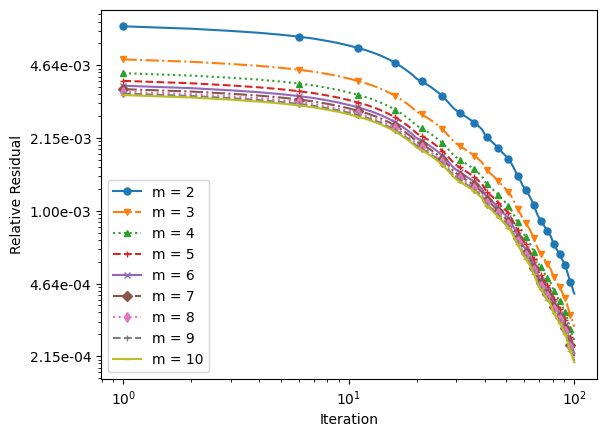

In [32]:
fig, ax = plt.subplots()

n = 100
A = five_pt_stencil(n)
b = np.random.rand(n * n)
true_x = np.linalg.solve(A.toarray(), b)

linestyles = ['-', '-.', ':', '--']
markers = ['o', 'v', '^', '+', 'x', 'D', 'd', '|', '_', '<', '>', 's', 'p', '*', 'h', 'H',]

class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.initial_residual_norm = None
        self.residuals = []

    def __call__(self, rk=None):
        self.niter += 1
        if self.initial_residual_norm is None:
            self.initial_residual_norm = rk

        relative_residual_norm = rk / self.initial_residual_norm
        self.residuals.append(rk)

        if self._disp:
            print('iter %3i\t|rk|/|r0| = %s' % (self.niter, str(relative_residual_norm)))

for i, m in enumerate(range(2, 11)):
    counter = gmres_counter(disp=False) #displayed in previous section already. only need plot comparing to the original papaer
    M = mos_d_preconditioner(A, m)
    x_gmres, info = gmres(A, b, maxiter=100, tol=1e-9, M=M, callback=counter)
    error = norm(true_x - x_gmres)
    print(f"m = {m}, Iterations: {counter.niter}, Norm of error: {error}")
    
    relative_residuals = []
    for rk in counter.residuals:
        relative_residual = rk**3 / counter.initial_residual_norm
        relative_residuals.append(relative_residual)
    ax.loglog(range(1, counter.niter + 1), relative_residuals, label=f"m = {m}", 
              linestyle=linestyles[i % len(linestyles)], marker=markers[i % len(markers)], markersize=5, markevery=5)

ax.set_xlabel("Iteration")
ax.set_ylabel("Relative Residual")
ax.legend()
def y_label(y, ind):
    return "{:.2e}".format(y**(1/3))
labeling = ticker.FuncFormatter(y_label)
ax.yaxis.set_major_formatter(labeling)
plt.show()


### MOS Adaptive

# WARNING!! THIS MAY TAKE REALLY LONG TO RUN (ESTIMATE: 25-30 MINS)

m = 2, Iterations: 85, Norm of error: 3.5849623221408094e-07
m = 3, Iterations: 85, Norm of error: 3.5849623221408094e-07
m = 4, Iterations: 85, Norm of error: 3.5849623221408094e-07
m = 5, Iterations: 85, Norm of error: 3.5849623221408094e-07
m = 6, Iterations: 85, Norm of error: 3.5849623221408094e-07
m = 7, Iterations: 85, Norm of error: 3.5849623221408094e-07
m = 8, Iterations: 85, Norm of error: 3.5849623221408094e-07
m = 9, Iterations: 85, Norm of error: 3.5849623221408094e-07
m = 10, Iterations: 85, Norm of error: 3.5849623221408094e-07


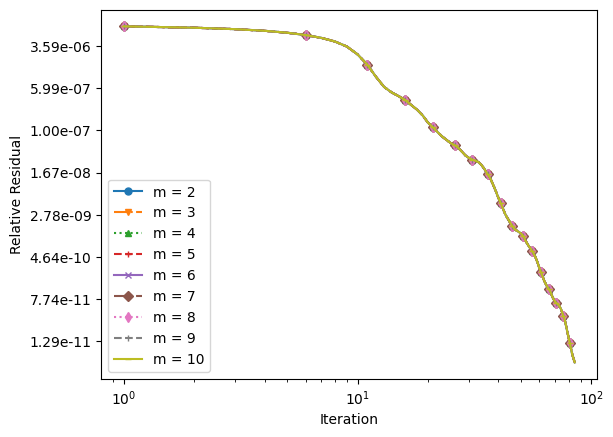

In [ ]:
fig, ax = plt.subplots()

n = 75
A = five_pt_stencil(n)
b = np.random.rand(n * n)
true_x = np.linalg.solve(A.toarray(), b)
q = np.full(n*n, 3)
linestyles = ['-', '-.', ':', '--']
markers = ['o', 'v', '^', '+', 'x', 'D', 'd', '|', '_', '<', '>', 's', 'p', '*', 'h', 'H',]

class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.initial_residual_norm = None
        self.residuals = []

    def __call__(self, rk=None):
        self.niter += 1
        if self.initial_residual_norm is None:
            self.initial_residual_norm = rk

        relative_residual_norm = rk / self.initial_residual_norm
        self.residuals.append(rk)

        if self._disp:
            print('iter %3i\t|rk|/|r0| = %s' % (self.niter, str(relative_residual_norm)))

for i, m in enumerate(range(2, 11)):
    counter = gmres_counter(disp=False) #displayed in previous section already. only need plot comparing to the original papaer
    M = mos_a_preconditioner(A, m, q)
    x_gmres, info = gmres(A, b, maxiter=120, tol=1e-6, M=M, callback=counter)
    error = norm(true_x - x_gmres)
    print(f"m = {m}, Iterations: {counter.niter}, Norm of error: {error}")
    
    relative_residuals = []
    for rk in counter.residuals:
        relative_residual = rk**9 / counter.initial_residual_norm
        relative_residuals.append(relative_residual)
    ax.loglog(range(1, counter.niter + 1), relative_residuals, label=f"m = {m}", 
              linestyle=linestyles[i % len(linestyles)], marker=markers[i % len(markers)], markersize=5, markevery=5)

ax.set_xlabel("Iteration")
ax.set_ylabel("Relative Residual")
ax.legend()
def y_label(y, ind):
    return "{:.2e}".format(y**(1/9))
labeling = ticker.FuncFormatter(y_label)
ax.yaxis.set_major_formatter(labeling)
plt.show()


# Thank you for coming! 

# Please don't hesitate to give a good peer review :)